# Markov chain Monte Carlo

A major takeaway from the previous section is the inherent difficulty in calculating or estimating posterior distributions for use in Bayesian inference. The two alternative strategies to obtaining posteriors for moderate to large models involve either analytic **approximations** or stochastic **sampling**. Approximations are usually valid conditional on assumptions regarding the true posterior distribution, which are typically impossible to validate. Direct sampling strategies rely on our ability to sample from the posterior distribution, and this is frequently not possible. Indirect sampling methods, such as rejection sampling, can be plagued with sampling efficiency issues.

The sampling approaches we have introduced so far have each attempted to obtain *independent* samples from the posterior distribution. It turns out, however, that it is possible to generate samples from the posterior distribution using a *dependent* sampling algorithm, and despite the dependence of the samples, one may extract valid inference from them. A class of algorithms called **Markov chain Monte Carlo** yields a Markovian sample (explained below) which, provided that certain conditions are satisfied, is guaranteed to be indistinguishable from a sample drawn from the true posterior itself.

## Markov Chains

A Markov chain is a special type of *stochastic process*. The standard definition of a stochastic process is an ordered collection of random variables:

$$\{X_t: t \in T\}$$

where $t$ is frequently (but not necessarily) a time index. If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:

$$Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)$$

then the stochastic process is known as a Markov chain. This conditioning specifies that the future depends on the current state, but not past states. Thus, the Markov chain wanders about the state space,
remembering only where it has just been in the last time step. The collection of transition probabilities is sometimes called a *transition matrix* when dealing with discrete states, or more generally, a
*transition kernel*.

In the context of Markov chain Monte Carlo, it is useful to think of the Markovian property as “mild non-independence”. MCMC allows us to indirectly generate independent samples from a particular posterior distribution.

### Markov Chain Jargon

Before we move on, it is important to define some general properties of Markov chains. They are frequently encountered in the MCMC literature, and some will help us decide whether MCMC is producing a useful sample from the posterior.

---

**Homogeneity**: A Markov chain is homogeneous at step $t$ if the transition probabilities are independent of time $t$. 
 
**Irreducibility** A Markov chain is irreducible if every state is accessible in one or more steps from any other state. That is, the chain contains no absorbing states. This implies that there is a non-zero probability of eventually reaching state $k$ from any other state in the chain. 
 
**Recurrence** States which are visited repeatedly are *recurrent*. If the expected time to return to a particular state is bounded, this is known as *positive recurrence*, otherwise the recurrent state is *null recurrent*. Further, a chain is *Harris recurrent* when it visits all states $X \in S$ infinitely often in the limit as $t \to \infty$; this is an important characteristic when dealing with unbounded, continuous state spaces. Whenever a chain ends up in a closed, irreducible set of Harris recurrent states, it stays there forever and visits every state with probability one. 
 
**Stationarity** A stationary Markov chain produces the same marginal distribution when multiplied by the transition kernel. Thus, if $P$ is some $n \times n$ transition matrix: 
 
$$\mathbf{\pi} P = \mathbf{\pi}$$
    
for Markov chain $\pi$. Thus, $\pi$ is no longer subscripted, and is referred to as the *limiting distribution* of the chain. In MCMC, the chain explores the state space according to its limiting marginal distribution. 
 
**Ergodicity**: Ergodicity is an emergent property of Markov chains which are irreducible, positive Harris recurrent and aperiodic. Ergodicity is defined as: 
 
$$\lim_{n \to \infty} Pr^{(n)}(\theta_i \rightarrow \theta_j) = \pi(\theta) \quad \forall \theta_i, \theta_j \in \Theta$$  
    
or in words, after many steps the marginal distribution of the chain is the 
same at one step as at all other steps. This implies that our Markov chain, 
which we recall is dependent, can generate samples that are independent if 
we wait long enough between samples. If it means anything to you, 
ergodicity is the analogue of the strong law of large numbers for Markov 
chains. For example, take values $\theta_{i+1},\ldots,\theta_{i+n}$
from a chain that has reached an ergodic state. A statistic of interest can 
then be estimated by:
 
$$\frac{1}{n}\sum_{j=i+1}^{i+n} h(\theta_j) \approx \int f(\theta) h(\theta) d\theta$$

---

## Why MCMC Works: Reversible Markov Chains

Markov chain Monte Carlo simulates a Markov chain for which some function of interest
(*e.g.* the joint distribution of the parameters of some model) is the unique, invariant limiting distribution. An invariant distribution with respect to some Markov chain with transition kernel $Pr(y \mid x)$ implies that:

$$\int_x Pr(y \mid x) \pi(x) dx = \pi(y).$$

Invariance is guaranteed for any *reversible* Markov chain. Consider a Markov chain in reverse sequence:
$\{\theta^{(n)},\theta^{(n-1)},...,\theta^{(0)}\}$. This sequence is still Markovian, because:

$$Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x,\theta^{(k+2)}=x_1,\ldots ) = Pr(\theta^{(k)}=y \mid \theta^{(k+1)}=x$$

Forward and reverse transition probabilities may be related through Bayes theorem:

$$\frac{Pr(\theta^{(k+1)}=x \mid \theta^{(k)}=y) \pi^{(k)}(y)}{\pi^{(k+1)}(x)}$$

Though not homogeneous in general, $\pi$ becomes homogeneous if:

-   $n \rightarrow \infty$

-   $\pi^{(i)}=\pi$ for some $i < k$

If this chain is homogeneous it is called reversible, because it satisfies the ***detailed balance equation***:

$$\pi(x)Pr(y \mid x) = \pi(y) Pr(x \mid y)$$

Reversibility is important because it has the effect of balancing movement through the entire state space. When a Markov chain is reversible, $\pi$ is the unique, invariant, stationary distribution of that chain. Hence, if $\pi$ is of interest, we need only find the reversible Markov chain for which $\pi$ is the limiting distribution.
This is what MCMC does!

## Gibbs Sampling

The Gibbs sampler is the simplest and most prevalent MCMC algorithm. If a posterior has $k$ parameters to be estimated, we may condition each parameter on current values of the other $k-1$ parameters, and sample from the resultant distributional form (usually easier), and repeat this operation on the other parameters in turn. This procedure generates samples from the posterior distribution. Note that we have now combined Markov chains (conditional independence) and Monte Carlo techniques (estimation by simulation) to yield Markov chain Monte Carlo.

Here is a stereotypical Gibbs sampling algorithm:

1.  Choose starting values for states (parameters):
    ${\bf \theta} = [\theta_1^{(0)},\theta_2^{(0)},\ldots,\theta_k^{(0)}]$

2.  Initialize counter $j=1$

3.  Draw the following values from each of the $k$ conditional
    distributions:

$$\begin{aligned}
\theta_1^{(j)} &\sim& \pi(\theta_1 | \theta_2^{(j-1)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_2^{(j)} &\sim& \pi(\theta_2 | \theta_1^{(j)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_3^{(j)} &\sim& \pi(\theta_3 | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\vdots \\
\theta_{k-1}^{(j)} &\sim& \pi(\theta_{k-1} | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_k^{(j-1)}) \\
\theta_k^{(j)} &\sim& \pi(\theta_k | \theta_1^{(j)},\theta_2^{(j)},\theta_4^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_{k-1}^{(j)})
\end{aligned}$$

4.  Increment $j$ and repeat until convergence occurs.

As we can see from the algorithm, each distribution is conditioned on the last iteration of its chain values, constituting a Markov chain as advertised. The Gibbs sampler has all of the important properties outlined in the previous section: it is aperiodic, homogeneous and ergodic. Once the sampler converges, all subsequent samples are from the target distribution. This convergence occurs at a geometric rate.

## Example: Inferring patterns in UK coal mining disasters

Let's try to model a more interesting example, a time series of recorded coal mining 
disasters in the UK from 1851 to 1962.

Occurrences of disasters in the time series is thought to be derived from a 
Poisson process with a large rate parameter in the early part of the time 
series, and from one with a smaller rate in the later part. We are interested 
in locating the change point in the series, which perhaps is related to changes 
in mining safety regulations.

In [1]:
import numpy as np

disasters_array = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

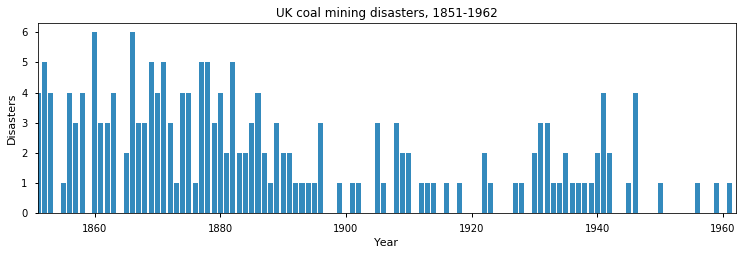

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

fig, ax = plt.subplots(figsize=(12.5, 3.5))
n_count_data = len(disasters_array)
ax.bar(np.arange(1851, 1962), disasters_array, color="#348ABD")
ax.set_xlabel("Year")
ax.set_ylabel("Disasters")
ax.set_title("UK coal mining disasters, 1851-1962")
ax.set_xlim(1851, 1962);

We are going to use Poisson random variables for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$ y_i \sim \text{Poisson}(\lambda)  $$

The modeling problem revolves around estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines later in the time series.

A ***changepoint model*** identifies a point (year) during the observation period (call it $\tau$) after which the parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: one for the early period and another for the late period.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We need to assign prior probabilities to both $\lambda$ parameters. The gamma distribution not only provides a continuous density function for positive numbers, but it is also **conjugate** with the Poisson sampling distribution. We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors.

$$\begin{aligned}
\lambda_1 &\sim \text{Gamma}( \alpha, \beta ) \cr
\lambda_2 &\sim \text{Gamma}( \alpha, \beta )
\end{aligned}$$

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.

$$\begin{aligned}
& \tau \sim \text{DiscreteUniform(1851,1962) }\cr
& \Rightarrow P( \tau = k ) = \frac{1}{111}
\end{aligned}$$

### Implementing Gibbs sampling

We are interested in estimating the joint posterior of $\lambda_1$, $\lambda_2$ and $\tau$ given the array of annnual disaster counts $\mathbf{y}$. This gives:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(\mathbf{y} | \lambda_1, \lambda_2, \tau ) P(\lambda_1, \lambda_2, \tau) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(y_{t<\tau} | \lambda_1, \tau) P(y_{t\ge \tau} | \lambda_2, \tau) P(\lambda_1) P(\lambda_2) P(\tau)
$$

which we have specified as:

$$\begin{aligned}
P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) &\propto \left[\prod_{t=1851}^{\tau} \text{Poi}(y_t|\lambda_1) \prod_{t=\tau+1}^{1962} \text{Poi}(y_t|\lambda_2) \right] \text{Gamma}(\lambda_1|\alpha,\beta) \text{Gamma}(\lambda_2|\alpha, \beta) \frac{1}{111} \\
&\propto \left[\prod_{t=1851}^{\tau} e^{-\lambda_1}\lambda_1^{y_t} \prod_{t=\tau+1}^{1962} e^{-\lambda_2} \lambda_2^{y_t} \right] \lambda_1^{\alpha-1} e^{-\beta\lambda_1} \lambda_2^{\alpha-1} e^{-\beta\lambda_2} \\
&\propto \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}
\end{aligned}$$

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.

$$\lambda_1 \sim \text{Gamma}(\sum_{t=1851}^{\tau} y_t +\alpha, \tau+\beta)$$
$$\lambda_2 \sim \text{Gamma}(\sum_{t=\tau+1}^{1962} y_i + \alpha, 1962-\tau+\beta)$$
$$\tau \sim \text{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right)$$

Implementing this in Python requires random number generators for both the gamma and discrete uniform distributions. We can leverage NumPy for this:

In [3]:
# Function to draw random gamma variate
rgamma = np.random.gamma

# Function to draw random categorical variate
rcategorical = lambda probs, n=None: np.array(probs).cumsum().searchsorted(np.random.sample(n))

Next, in order to generate probabilities for the conditional posterior of $\tau$, we need the kernel of the gamma density:

In [4]:
dgamma = lambda lam, a, b: lam**(a-1) * np.exp(-b*lam)

Diffuse hyperpriors for the gamma priors on $\lambda_1, \lambda_2$:

In [5]:
alpha, beta = 1., 10

For computational efficiency, it is best to pre-allocate memory to store the sampled values. We need 3 arrays, each with length equal to the number of iterations we plan to run:

In [6]:
# Specify number of iterations
n_iterations = 1000

# Initialize trace of samples
lambda1, lambda2, tau = np.empty((3, n_iterations+1))

The penultimate step initializes the model paramters to arbitrary values:

In [7]:
lambda1[0] = 6
lambda2[0] = 2
tau[0] = 50

Now we can run the Gibbs sampler.

In [8]:
# Sample from conditionals
for i in range(n_iterations):
    
    # Sample early mean
    lambda1[i+1] = rgamma(disasters_array[:int(tau[i])].sum() + alpha, 1./(tau[i] + beta))
    
    # Sample late mean
    lambda2[i+1] = rgamma(disasters_array[int(tau[i]):].sum() + alpha, 
                          1./(n_count_data - tau[i] + beta))
    
    # Sample changepoint
    p = np.array([dgamma(lambda1[i+1], disasters_array[:t].sum() + alpha, t + beta)*
             dgamma(lambda2[i+1], disasters_array[t:].sum() + alpha, n_count_data - t + beta)
             for t in range(n_count_data)])
    tau[i+1] = rcategorical(p/p.sum())


Plotting the trace and histogram of the samples reveals the marginal posteriors of each parameter in the model.

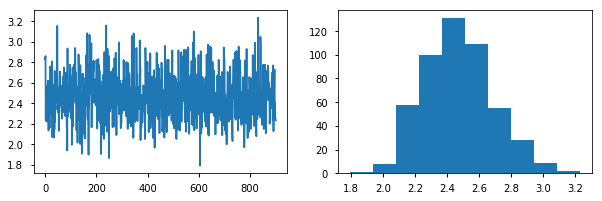

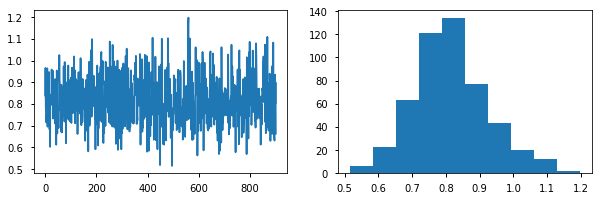

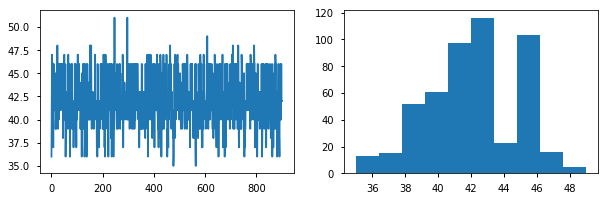

In [9]:
for samples in lambda1, lambda2, tau:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].plot(samples[100:])
    axes[1].hist(samples[int(n_iterations/2):])

## The Metropolis-Hastings Algorithm

The key to success in applying the Gibbs sampler to the estimation of Bayesian posteriors is being able to specify the form of the complete conditionals of
${\bf \theta}$. In fact, the algorithm cannot be implemented without them. Of course, the posterior conditionals cannot always be neatly specified. In contrast to the Gibbs algorithm, the Metropolis-Hastings algorithm generates candidate state transitions from an alternate distribution, and accepts or rejects each candidate probabilistically.

Let us first consider a simple Metropolis-Hastings algorithm for a single parameter, $\theta$. We will use a standard sampling distribution, referred to as the **proposal distribution**, to produce candidate variables $q_t(\theta^{\prime} | \theta)$. That is, the generated value, $\theta^{\prime}$, is a *possible* next value for
$\theta$ at step $t+1$. We also need to be able to calculate the probability of moving back to the original value from the candidate, or $q_t(\theta | \theta^{\prime})$. These probabilistic ingredients are used to define an **acceptance ratio**:

$$a(\theta^{\prime},\theta) = \frac{q_t(\theta^{\prime} | \theta) \pi(\theta^{\prime})}{q_t(\theta | \theta^{\prime}) \pi(\theta)}$$

The value of $\theta^{(t+1)}$ is then determined by:

$$
\theta^{(t+1)} = 
\begin{cases}
\theta^{\prime}  & \text{with prob. } \min(a(\theta^{\prime},\theta^{(t)}),1)\cr
\theta^{(t)}  & \text{with prob } 1 - \min(a(\theta^{\prime},\theta^{(t)}),1)
\end{cases}
$$

This transition kernel implies that movement is not guaranteed at every step. It only occurs if the suggested transition is likely based on the acceptance ratio.

A single iteration of the Metropolis-Hastings algorithm proceeds as follows:

The original form of the algorithm specified by Metropolis required that
$q_t(\theta^{\prime} | \theta) = q_t(\theta | \theta^{\prime})$, which reduces $a(\theta^{\prime},\theta)$ to
$\pi(\theta^{\prime})/\pi(\theta)$, but this is not necessary. In either case, the state moves to high-density points in the distribution with high probability, and to low-density points with low probability. After convergence, the Metropolis-Hastings algorithm describes the full target posterior density, so all points are recurrent.

1.  Sample $\theta^{\prime}$ from $q(\theta^{\prime} | \theta^{(t)})$.

2.  Generate a Uniform[0,1] random variate $u$.

3.  If $a(\theta^{\prime},\theta) > u$ then
    $\theta^{(t+1)} = \theta^{\prime}$, otherwise
    $\theta^{(t+1)} = \theta^{(t)}$.

### Random-walk Metropolis-Hastings

A practical implementation of the Metropolis-Hastings algorithm makes use of a random-walk proposal.
Recall that a random walk is a Markov chain that evolves according to:

$$\begin{aligned}
\theta^{(t+1)} &= \theta^{(t)} + \epsilon_t \\
\epsilon_t &\sim f(\phi)
\end{aligned}$$

As applied to the MCMC sampling, the random walk is used as a proposal distribution, whereby dependent proposals are generated according to:

$$q(\theta^{\prime} | \theta^{(t)}) = f(\theta^{\prime} - \theta^{(t)}) = \theta^{(t)} + \epsilon_t$$

Generally, the density generating $\epsilon_t$ is symmetric about zero,
resulting in a symmetric chain. Chain symmetry implies that
$q(\theta^{\prime} | \theta^{(t)}) = q(\theta^{(t)} | \theta^{\prime})$,
which reduces the Metropolis-Hastings acceptance ratio to:

$$a(\theta^{\prime},\theta) = \frac{\pi(\theta^{\prime})}{\pi(\theta)}$$

The choice of the random walk distribution for $\epsilon_t$ is frequently a normal or Student’s $t$ density, but it may be any distribution that generates an irreducible proposal chain.

An important consideration is the specification of the scale parameter for the random walk error distribution. Large values produce random walk steps that are highly exploratory, but tend to produce proposal values in the tails of the target distribution, potentially resulting in very small acceptance rates. Conversely, small values tend to be accepted more frequently, since they tend to produce proposals close to the current parameter value, but may result in chains that mix very slowly.
Some simulation studies suggest optimal acceptance rates in the range of 20-50%. It is often worthwhile to optimize the proposal variance by iteratively adjusting its value, according to observed acceptance rates early in the MCMC simulation .

## Example: Linear model estimation

This very simple dataset is a selection of real estate prices, with the associated age of each house. We wish to estimate a simple linear relationship between the two variables, using the Metropolis-Hastings algorithm.

$$\mu_i = \beta_0 + \beta_1 a_i$$

$$p_i \sim N(\mu_i, \tau)$$

In [ ]:
age = np.array([13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10])
price = np.array([2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700])/1000.

This function calculates the joint log-posterior, conditional on values for each paramter:

In [ ]:
from scipy.stats import gamma, norm
dgamma = gamma.logpdf
dnorm = norm.logpdf

def calc_posterior(a, b, t, y=price, x=age):
    # Calculate joint posterior, given values for a, b and t

    # Priors on a,b
    logp = dnorm(a, 0, 10000) + dnorm(b, 0, 10000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = a + b*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

In [ ]:
rnorm = np.random.normal
runif = np.random.rand


def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
                
    return trace, accepted

Let's run the MH algorithm with a very small proposal variance:

In [ ]:
n_iter = 10000
trace, acc = metropolis(n_iter, (1,0,1), 0.001)

We can see that the acceptance rate is way too high:

In [ ]:
np.array(acc, float)/n_iter

In [ ]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

Now, with a very large proposal variance:

In [ ]:
trace_hivar, acc = metropolis(n_iter, (1,0,1), 10)

In [ ]:
np.array(acc, float)/n_iter

In [ ]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_hivar.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

In order to avoid having to set the proposal variance by trial-and-error, we can add some tuning logic to the algorithm. 

## Exercise: auto-tuning Metropolis-Hastings

Modify the Metropolis-Hastings algorithm above by adding logic to automatically change the proposal scale depending on the acceptance rate of the chain. Call the new function `metropolis_tuned`.

In [ ]:
# Write your answer here

In [ ]:
trace_tuned, acc = metropolis_tuned(n_iter, (1,0,1))

In [ ]:
np.array(acc, float)/1000

In [ ]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace_tuned.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

A useful way to informally examine the fit of the model is to examine functions of the posterior distribution. For example, here are 50 random regression lines drawn from the posterior:

In [ ]:
plt.plot(age, price, 'bo')
plt.xlabel('age (years)'); plt.ylabel('price ($1000\'s)')
xvals = np.linspace(age.min(), age.max())
for i in range(50):
    b0,b1,tau = trace_tuned[np.random.randint(0, 1000)]
    plt.plot(xvals, b0 + b1*xvals, 'r-', alpha=0.2)

## Exercise: Bioassay analysis

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is `death`, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Bin}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the **LD50**, the dosage at which the probability of death is 50%.

Use Metropolis-Hastings sampling to fit a Bayesian model to analyze this bioassay data, and to estimate LD50.

In [ ]:
# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [ ]:
# Write your answer here

## Slice Sampling

Though Gibbs sampling is very computationally efficient, it can be difficult to implement in a general way, whereas the Metropolis-Hastings algorithm is relatively inefficient, while being easy to implement for a variety of models. We have seen that it is possible to tune Metropolis samplers, but it would be nice to have a "black-box" method that works for arbitrary continuous distributions, which we may know little about *a priori*.

The ***slice sampler*** bridges this gap by being both efficient and easy to program generally.
The idea is to first sample from the conditional distribution for $y$ given some current value of $x$, which is uniform over the $(0, f (x))$, and conditional on this value for $y$, then sample $x$, which is uniform on $S = {x : y < f (x)}$, that is the “slice” defined by the $y$ value. Hence, this algorithm automatically adapts to the local characteristics of the posterior.

The steps required to perform a single iteration of the slice sampler to update the current value of $x_i$ is as follows:

1. Sample $y$ uniformly on $(0,f(x_i))$. 
2. Use this value $y$ to define a horizontal *slice* $S = \{x : y < f (x)\}$. 
3. Establish an interval, $I = (x_{a}, x_{b})$, around $x_i$ that contains most of the slice.
4. Sample $x_{i+1}$ from the region of the slice overlaping $I$.

Hence, slice sampling employs an **auxilliary variable** ($y$) that is not retained at the end of the iteration. Note that in practice one may operate on the log scale such that $g(x) = \log(f (x))$ to avoid floating-point underflow. In this case, the auxiliary variable becomes $z = log(y) = g(x_i) − e$, where $e \sim \text{Exp}(1)$, resulting in the slice $S = \{x : z < g(x)\}$.

There are many ways of establishing and sampling from the interval $I$, with the only restriction being that the resulting Markov chain leaves $f(x)$ *invariant*. The objective is to include as much of the slice as possible, so that the potential step size can be large, but not (much) larger than the slice, so that the sampling of invalid points is minimized. Ideally, we would like it to be the slice itself, but it may not always be feasible to determine (and certainly not automatically).

### Stepping out

One method for determining a sampling interval for $x_{i+1}$  involves specifying an initial "guess" at the slice width $w$, and iteratively moving the endpoints out (growing the interval) until either (1) the interval reaches a maximum pre-speficied width or (2) $y$ is less than the $f(x)$ evaluated both at the left and the right interval endpoints.

In [ ]:
def step_out(func, x0, y, w, m=np.inf):
    """
    func: target function (evaluates at x)
    x0: current value of x
    y: y-value that defines slice
    w: estimate of slice width
    m: factor limiting interval to size m*w (defaults to infinity)
    
    Returns end points of a sampling interval for slice at y
    """

    left = x0 - w*np.random.random()
    right = left + w
    
    i = np.floor(m*np.random.random())
    j = (m-1) - i
    
    while (i > 0) and (y < func(left)):
        left -= w
        i -= 1
        
    while (j > 0) and (y < func(right)):
        right += w
        j -= 1
        
    return left, right

In [ ]:
from scipy.stats import gamma
gam = gamma(2, scale=1).pdf

xvals = np.linspace(0, 10)
plt.plot(xvals, gam(xvals))

x, y = 1, 0.03
l,r = step_out(gam, x, y, 1, 5)
plt.plot((l,r), (y,y), 'r-')

x, y = 1, 0.3
l,r = step_out(gam, x, y, 1, 5)
plt.plot((l,r), (y,y), 'm-')

### Doubling

The efficiency of stepping out depends largely on the ability to pick a reasonable interval $w$ from which to sample. Otherwise, the doubling procedure may be preferable, as it can be expanded faster. It simply doubles the size of the interval until both endpoints are outside the slice. 

In [ ]:
def doubling(func, x0, y, w, p=10):
    """
    func: target function (evaluates at x)
    x0: current value of x
    y: y-value that defines slice
    w: estimate of slice width
    p: integer limiting interval to size m*w (defaults to infinity)
    
    Returns end points of a sampling interval for slice at y
    """

    left = x0 - w*np.random.random()
    right = left + w
    
    while (p > 0) and ((y < func(left)) or (y < func(right))):
        
        if np.random.random() < 0.5:
            
            left -= right - left
            
        else:
            
            right += right - left
            
        p -= 1
        
    return left, right

In [ ]:
gam = gamma(2, scale=1).pdf

xvals = np.linspace(0, 10)
plt.plot(xvals, gam(xvals))

x, y = 1, 0.03
l,r = doubling(gam, x, y, 1)
plt.plot((l,r), (y,y), 'r-')

x, y = 1, 0.3
l,r = doubling(gam, x, y, 1)
plt.plot((l,r), (y,y), 'm-')

Irrespective of which method for interval determination is used, the next step is to draw a value from this interval. One condition that applies to the new point is that it should be as likely to draw the interval $I$ from the new value as it was from the current value.

There are two approaches that could be taken:

1. Draw from $I$ until a suitable point is obtained
2. Draw from $I$, which shrinks by some factor each time an unsuitable point is drawn, until a suitable point is obtained

A shrinkage function might proceed as follows:

In [ ]:
def shrink(func, x0, y, left, right, w):
    
    l, r = left, right
    
    while True:
    
        x1 = l + np.random.random()*(r - l)
        
        if (y < func(x1)) and check_value(x0, x1, l, r, y, func, w):
            return x1
        
        if x1 < x0:
            l = x1
        else:
            r = x1

If a doubling procedure was used to expand the sampling interval, we require an acceptance function to ascertain whether a given point satisfies the criterion above.

In [ ]:
def check_value(x0, x1, left, right, y, func, w):
    
    l, r = left, right
    
    m = (l + r)/2.
    
    differ = False
    
    while (r - l) > (1.1*w):
    
        if ((x0 < m) and (x1 >= m)) or ((x0 >= m) and (x1 < m)):
            # Intervals generated from new point likely different
            differ = True
            
        # Reduce interval
        if x1 < m:
            r = m
        else:
            l = m
            
        if differ and (y >= func(l)) and (y >= func(r)):
            # Point is not acceptable
            return False
    
    # If not rejected above, accept
    return True

Otherwise we can just substitute a trivial function for `check_value`:

    check_value = lambda *args, **kwargs: return True

In [ ]:
uniform = np.random.uniform

def slice(n_iterations, logp, initial_values, w=1, tune=True):
    
    n_params = len(initial_values)
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
    
    w_tune = []

    for i in range(n_iterations):
        
        if not i%1000: print('Iteration %i' % i)

        q = trace[i]
        q0 = q.copy()

        w = np.resize(w, len(q0))

        y = logp(*q0) - np.random.exponential()

        # Stepping out procedure
        ql = q0.copy()
        ql -= uniform(0, w)
        qr = q0.copy()
        qr = ql + w

        yl = logp(*ql)
        yr = logp(*qr)

        while((y < yl).all()):
            ql -= w
            yl = logp(*ql)

        while((y < yr).all()):
            qr += w
            yr = logp(*qr)
        
        while True:

            # Sample uniformly from slice
            qi = uniform(ql, qr)

            yi = logp(*qi)

            if yi > y:
                q = qi
                break
            elif (qi > q).all():
                qr = qi
            elif (qi < q).all():
                ql = qi

        if tune:
            # Tune sampler parameters
            w_tune.append(abs(q0 - q))
            w = 2 * sum(w_tune, 0) / len(w_tune)

        trace[i+1] = q
        
    return trace

In [ ]:
n_iterations = 5000
trace = slice(n_iterations, calc_posterior, (1,0,1))

In [ ]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples )
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iterations/2):])

## Exercise: Doubling

Modify the slice sampler above to use doubling rather than stepping out to select the horizontal slice.

In [ ]:
# Write your answer here

## Reading Assignment

[Geyer C. (2011)](http://www.mcmchandbook.net/HandbookChapter1.pdf) Introduction to Markov Chain Monte Carlo. Handbook of Markov Chain Monte Carlo: Methods and Applications. 1–46.

---
## References

Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (2003). Bayesian Data Analysis, Second Edition (Chapman & Hall/CRC Texts in Statistical Science) (2nd ed.). Chapman and Hall/CRC.

Neal, R. M. (2003). Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198